# Homework 2

In this homework, we will explore a small dataset of 60 songs annotated with emotion using GEMS model. You received a folder with music files (one minute excerpts), a folder with automatically extracted chords that were parsed for you into chord root, chord triad type and chord extension, and emotional annotations in a CSV file.


Prerequisites: install **pandas, scikit learn**.

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from tqdm import tqdm

import os

# learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# viz
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# audio
from IPython.display import Audio

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""

    where am i?

"""

PATH = os.getcwd() + '/'

ch_path = PATH + 'chords/'
mu_path = PATH + 'music/'

print(f'PATH: {PATH}')
print(f'chords path: {ch_path}')
print(f'music path: {mu_path}')

PATH: /Users/no_lineal/Documents/GitHub/music_information_retrieval/hw02/
chords path: /Users/no_lineal/Documents/GitHub/music_information_retrieval/hw02/chords/
music path: /Users/no_lineal/Documents/GitHub/music_information_retrieval/hw02/music/


#### <font color='red'> Exercise 1 (3 points). Design and extract some features based on the extracted chords (you might try number of unique chords or chord stems, consider summing up chord durations for a specific chord type, etc.) </font>

In [3]:
"""

    load data

"""

mu_ss = sorted(os.listdir( mu_path ))
ch_ss = sorted(os.listdir( ch_path ))

print(f'lenght sample space: { len(mu_ss) }')
print(f'lenght chord sample space: { len(ch_ss) }')

lenght sample space: 60
lenght chord sample space: 60


In [4]:
"""

    sample chords

"""

sample = np.random.choice( ch_ss ) 

print(f'sample: {sample}')

example_chord_file = pd.read_csv( ch_path + sample )
example_chord_file.head()

sample: 13.csv


chord chord_root chord_triad chord_addition  chord_duration
0     E          E        None           None        0.046440
1     B          B        None           None        1.439637
2     E          E        None           None        1.439637
3     A          A        None           None        1.393197
4   F#m         F#           m           None        1.532517

In [5]:
"""

    complete chords

"""

ch_df = pd.DataFrame()

for s in tqdm(ch_ss):
    
    if ch_df.empty:
        
        aux = pd.read_csv( ch_path + s )
        aux['sample'] = s.replace('.csv', '')
        
        ch_df = aux
        
    else:
        
        aux = pd.read_csv( ch_path + s )
        aux['sample'] = s.replace('.csv', '')
        
        ch_df = pd.concat( [ ch_df, aux ], axis=0 )
        
miss = set([ x.replace('.csv', '') for x in ch_ss ]) - set(ch_df['sample'].unique())

print(f'samples chords: {ch_df["sample"].nunique()}')
print(f'missing chords from: { miss }\n')
ch_df.info()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 990.20it/s]

samples chords: 59
missing chords from: {'206'}

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 35
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   chord           1679 non-null   object 
 1   chord_root      1679 non-null   object 
 2   chord_triad     1679 non-null   object 
 3   chord_addition  1679 non-null   object 
 4   chord_duration  1679 non-null   float64
 5   sample          1679 non-null   object 
dtypes: float64(1), object(5)
memory usage: 91.8+ KB


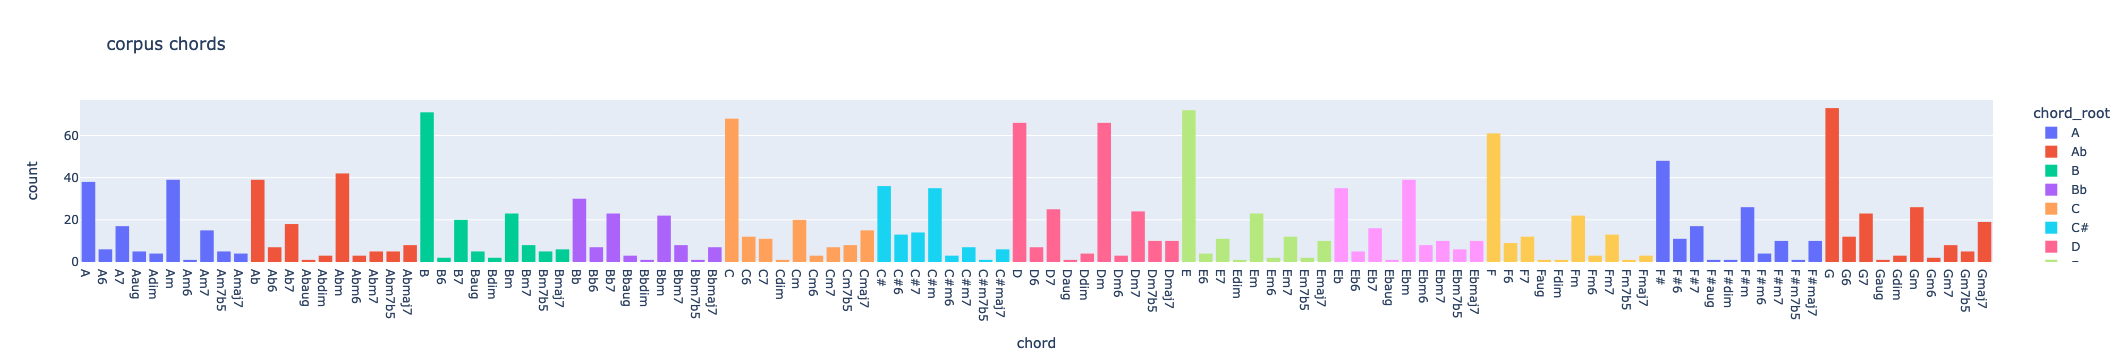

In [6]:
"""

    chord histogram

"""

aux = ch_df.sort_values(by=['chord', 'chord_root'])

fig = px.histogram( aux, x='chord', color='chord_root', title='corpus chords' )
fig.show()

In [7]:
"""

    features

"""

print(f'\ntotal number of chords: {ch_df["chord"].nunique()}')
print(f'\ntotal number of root chords: {ch_df["chord_root"].nunique()}')

# initialize features dataframe

ch_features = pd.DataFrame()

# number of chords normalized with respect to the chords observed in the corpus

ch_features = ch_df.groupby(['sample'])['chord'].nunique().reset_index().copy()

# number of root chords normalized with respect to the root chords observed in the corpus

aux = ch_df.groupby(['sample'])['chord_root'].nunique().reset_index().copy()

ch_features = ch_features.merge(aux, on='sample', how='right')

# root chord duration normalized with respect to the track duration

aux = ch_df.groupby(['sample', 'chord_root'])['chord_duration'].sum().reset_index(name='duration')
aux['total'] = aux.groupby('sample')['duration'].transform('sum')
aux['norm_duration'] = aux['duration']/ aux['total']
aux = aux.pivot( index='sample', columns='chord_root', values='norm_duration' ).reset_index().fillna(0.0)
aux.columns = [ x + '_d' if x != 'sample' else 'sample' for x in aux.columns ]

ch_features = ch_features.merge(aux, on='sample', how='right')

# chords representation

aux = ch_df.groupby(['sample', 'chord_root']).size().reset_index(name='count')
aux['total'] = aux.groupby('sample')['count'].transform('sum')
aux['norm_count'] = aux['count'] / aux['total']
aux = aux.pivot(index='sample', columns='chord_root', values='norm_count').reset_index().fillna(0.0)
ch_features = ch_features.merge( aux, on='sample', how='right' )

ch_features['sample'] = ch_features['sample'].astype('int')
ch_features.sort_values(by=['sample'])

# features dataframe

features = [ x for x in ch_features if x not in ['sample', 'chord', 'chord_root'] ]

print(f'\nfeatures: \n{features}')
ch_features.head()


total number of chords: 113

total number of root chords: 12

features: 
['A_d', 'Ab_d', 'B_d', 'Bb_d', 'C_d', 'C#_d', 'D_d', 'E_d', 'Eb_d', 'F_d', 'F#_d', 'G_d', 'A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'E', 'Eb', 'F', 'F#', 'G']


sample  chord  chord_root       A_d      Ab_d       B_d      Bb_d  \
0       1     30          10  0.059247  0.183347  0.034428  0.019215   
1      10     14           7  0.000000  0.475645  0.021968  0.048711   
2     101     18           6  0.279272  0.000000  0.034019  0.075949   
3     102     12           5  0.000000  0.000000  0.046603  0.000000   
4     103     13           8  0.261277  0.000000  0.211064  0.000000   

        C_d      C#_d       D_d  ...         B        Bb         C        C#  \
0  0.013611  0.183347  0.000000  ...  0.063830  0.021277  0.021277  0.212766   
1  0.030564  0.177650  0.000000  ...  0.026316  0.078947  0.026316  0.210526   
2  0.162975  0.000000  0.267405  ...  0.048780  0.048780  0.097561  0.000000   
3  0.487362  0.000000  0.049763  ...  0.035714  0.000000  0.357143  0.000000   
4  0.057021  0.000000  0.000000  ...  0.192308  0.000000  0.076923  0.000000   

          D         E        Eb         F        F#         G  
0  0.000000  0.106383  0.106383  0.000000  0.212766  0.021277  
1  0.000000  0.052632  0.236842  0.000000  0.000000  0.000000  
2  0.341463  0.000000  0.000000  0.073171  0.000000  0.000000  
3  0.107143  0.107143  0.000000  0.000000  0.000000  0.392857  
4  0.000000  0.230769  0.076923  0.038462  0.076923  0.153846  

[5 rows x 27 columns]

**Three types of features are extracted from the corpus**

**- chord set per track**

**- root chord set per track**

**- normalized time duration of root chords with respect to the duration of the track**

#### <font color='red'> Exercise 2 (2 points). Cluster the music files based on your features. You can choose a different number of clusters. Then listen to the music and look at the cluster statistics and describe your clusters. </font>

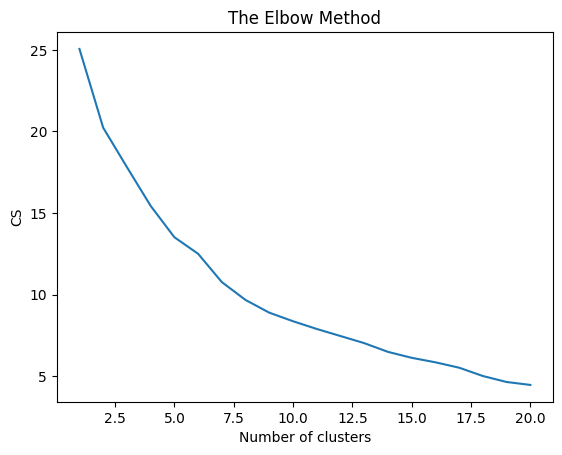

In [8]:
"""

    clustering elbow plot

"""

X = ch_features[ features ]

cs = []
for i in range(1, 21):
    
    kmeans = KMeans(
        n_clusters=i, 
        init='k-means++', 
        max_iter=500, 
        n_init=10, 
        random_state=42
    )
    
    kmeans.fit(X)
    
    cs.append( kmeans.inertia_ )
    
plt.plot(range(1, 21), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [9]:
"""

    cluster choosing

"""

# numeber of clusters
n = 4

kmeans = KMeans(
        n_clusters=n, 
        init='k-means++', 
        max_iter=500, 
        n_init=10, 
        random_state=42
    )

kmeans.fit(X)

labels = kmeans.labels_

ch_features['label'] = labels

ch_features.head()

sample  chord  chord_root       A_d      Ab_d       B_d      Bb_d  \
0       1     30          10  0.059247  0.183347  0.034428  0.019215   
1      10     14           7  0.000000  0.475645  0.021968  0.048711   
2     101     18           6  0.279272  0.000000  0.034019  0.075949   
3     102     12           5  0.000000  0.000000  0.046603  0.000000   
4     103     13           8  0.261277  0.000000  0.211064  0.000000   

        C_d      C#_d       D_d  ...        Bb         C        C#         D  \
0  0.013611  0.183347  0.000000  ...  0.021277  0.021277  0.212766  0.000000   
1  0.030564  0.177650  0.000000  ...  0.078947  0.026316  0.210526  0.000000   
2  0.162975  0.000000  0.267405  ...  0.048780  0.097561  0.000000  0.341463   
3  0.487362  0.000000  0.049763  ...  0.000000  0.357143  0.000000  0.107143   
4  0.057021  0.000000  0.000000  ...  0.000000  0.076923  0.000000  0.000000   

          E        Eb         F        F#         G  label  
0  0.106383  0.106383  0.000000  0.212766  0.021277      1  
1  0.052632  0.236842  0.000000  0.000000  0.000000      3  
2  0.000000  0.000000  0.073171  0.000000  0.000000      0  
3  0.107143  0.000000  0.000000  0.000000  0.392857      0  
4  0.230769  0.076923  0.038462  0.076923  0.153846      1  

[5 rows x 28 columns]

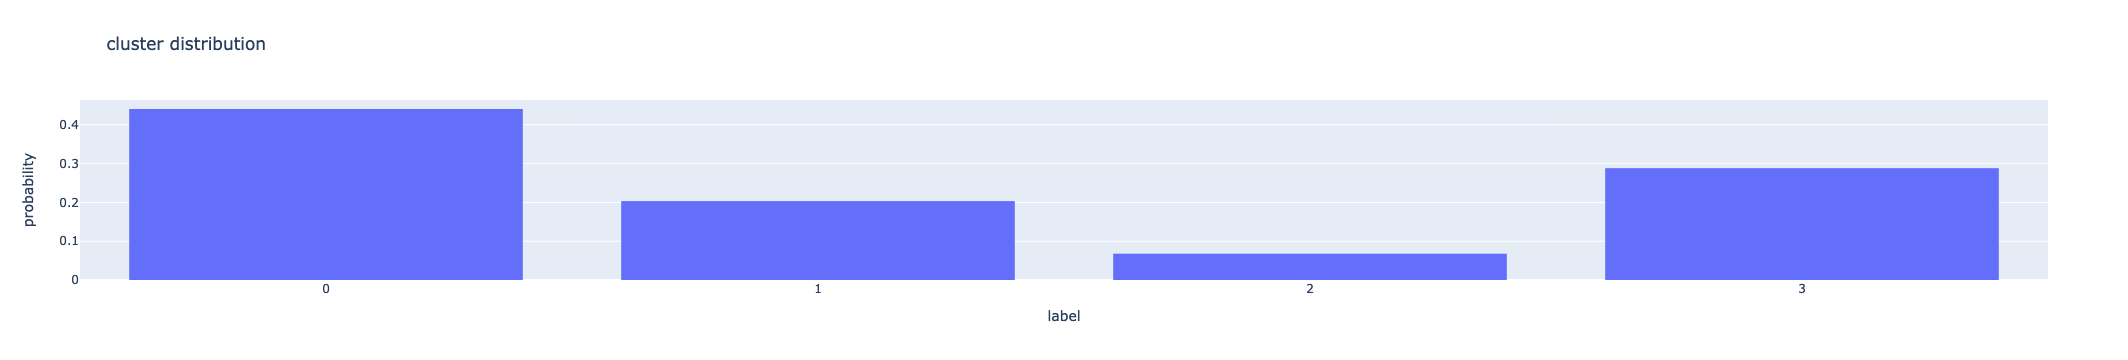

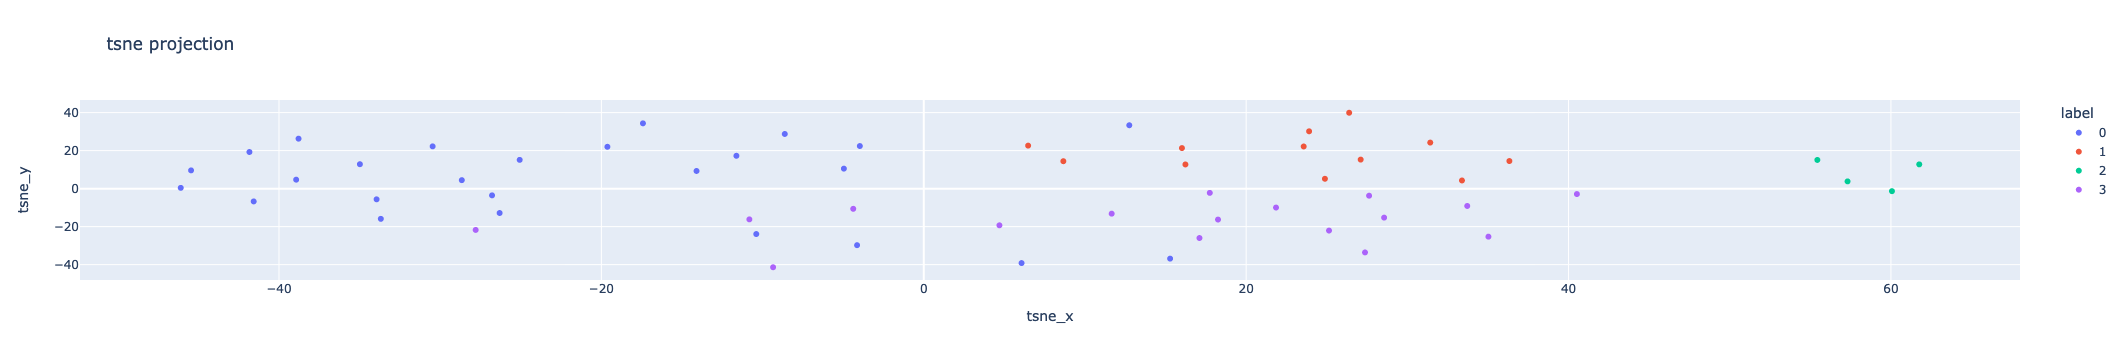

In [10]:
"""

    2D projection

"""


# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200)
df_tsne = tsne.fit_transform(ch_features[ features ].iloc[:, :-1])

# Add t-SNE components to dataframe
ch_features['tsne_x'] = df_tsne[:, 0]
ch_features['tsne_y'] = df_tsne[:, 1]

ch_features['label'] = ch_features['label'].astype('str')
ch_features = ch_features.sort_values(by=['label'])

# histogram clusters
fig = px.histogram(ch_features, x='label', histnorm='probability', title='cluster distribution')
fig.show()

# tsne viz
fig = px.scatter(ch_features, x='tsne_x', y='tsne_y', color='label', title='tsne projection')
fig.show()

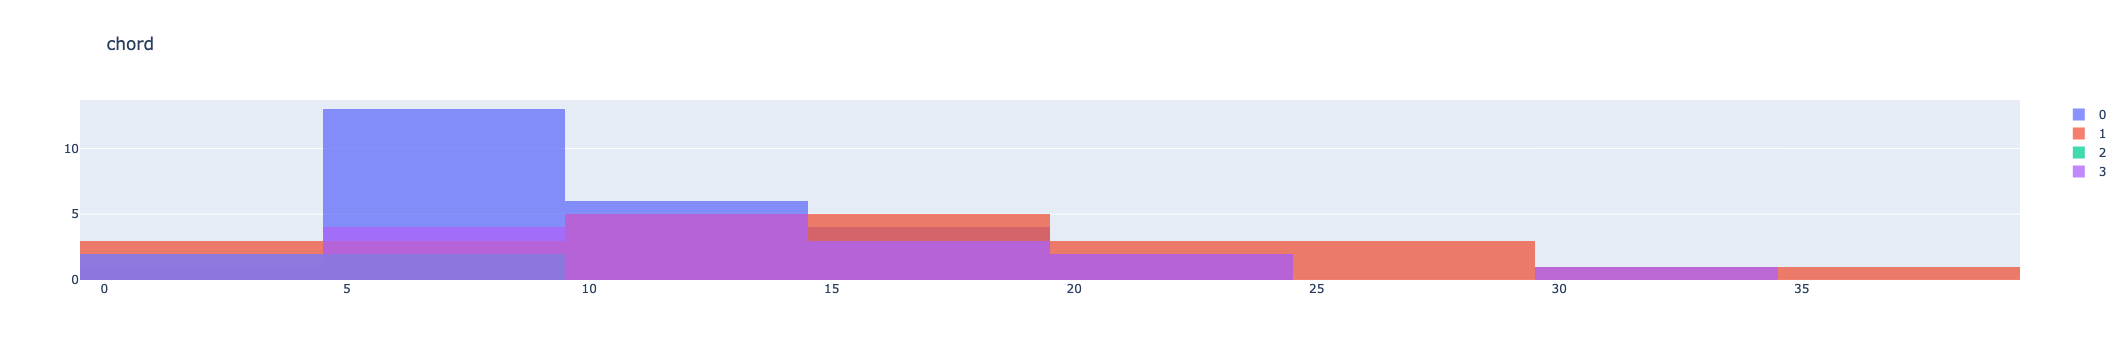

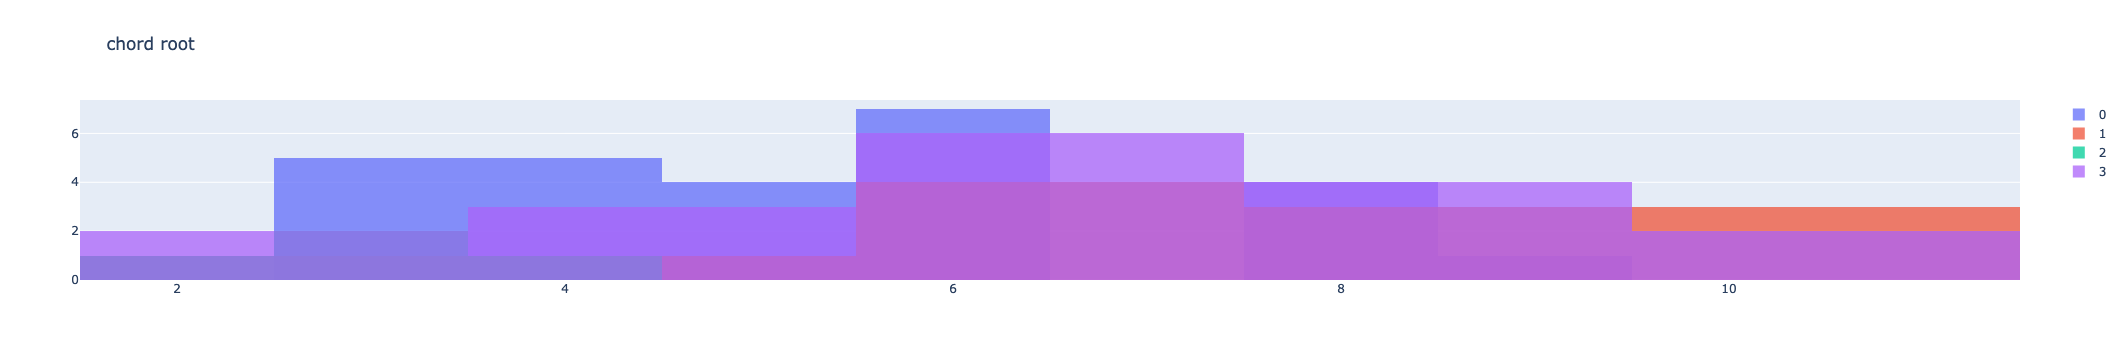

In [11]:
"""

    feature viz

"""

fig = go.Figure()

for c in ch_features['label'].unique():
    
    fig.add_trace( go.Histogram( x=ch_features[ ch_features['label'] == c ]['chord'], name=str(c) ) )
    
# Overlay both histograms
fig.update_layout(barmode='overlay', title='chord')
fig.update_traces(opacity=0.75)
fig.show()

fig = go.Figure()

for c in ch_features['label'].unique():
    
    fig.add_trace( go.Histogram( x=ch_features[ ch_features['label'] == c ]['chord_root'], name=str(c) ) )
    
# Overlay both histograms
fig.update_layout(barmode='overlay', title='chord root')
fig.update_traces(opacity=0.75)
fig.show()

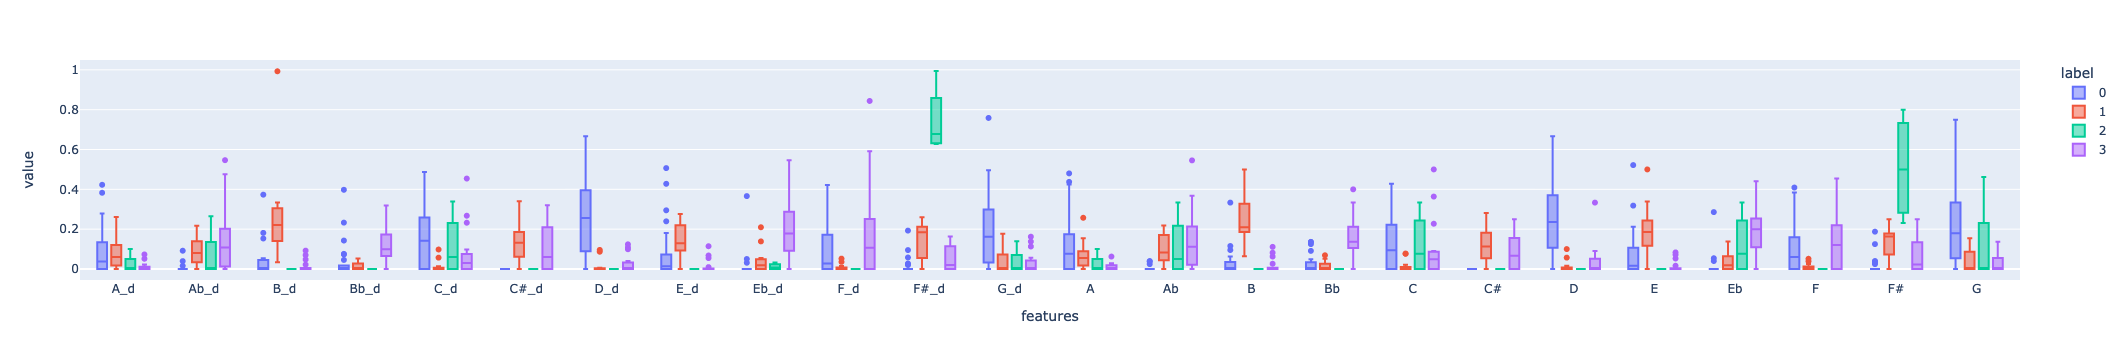

In [12]:
"""

    features according to label

"""

aux = ch_features[ features + ['label'] ]
aux = aux.set_index('label').T.reset_index().rename(columns={'index': 'features'})
aux = aux.melt( id_vars='features', var_name='label', value_name='value' )

fig = px.box( aux, x='features', y='value', color='label')
fig.show()

In [13]:
"""

    random sampling

"""

for c in ch_features['label'].unique():
    
    aux = ch_features[ ch_features['label'] == c ]
    sample = str(np.random.choice( aux['sample'].unique() )) + '.mp3'
    
    print(f'sample from cluster {c}: {sample}')
    display(Audio( mu_path + sample, autoplay=False ))

sample from cluster 0: 306.mp3


sample from cluster 1: 106.mp3


sample from cluster 2: 211.mp3


sample from cluster 3: 311.mp3


#### <font color='red'> Listen to the songs in your clusters and describe the clusters that you found. What characteristics do they have? </font>

**After fitting the data using k-means, we found that the transitions between most of the clusters are very smooth when listened to, except for clusters [0, 2]. These two clusters were also found to be the most distant from each other based on their distribution and projection.**

**The two more separated clusters also differ in the energy (perceptual) that they can evoke in the listener.**

#### <font color='red'> Exercise 3 (3 points). Now use your extracted features to predict one or more of the emotional dimensions of your choice. </font>

In [14]:
"""

    load emotions dataset

"""

emotions = pd.read_csv( PATH + 'emotion_annotations.csv' )
emotions['song_id'] = emotions['song_id'].apply( lambda x: x.replace('.mp3', '') )
emotions = emotions.rename(columns={'song_id': 'sample'})
emotions['sample'] = emotions['sample'].astype(str)

emotions.head()

sample  amazement  solemnity  tenderness  nostalgia  calmness   power  \
0      1     0.1842     0.3684      0.1842     0.2632    0.7105  0.0263   
1      2     0.1220     0.1951      0.4634     0.3415    0.7073  0.0488   
2      3     0.2162     0.2973      0.1351     0.2162    0.0811  0.2973   
3      4     0.1429     0.1429      0.5429     0.4286    0.8000  0.0286   
4      5     0.0541     0.3243      0.2973     0.5135    0.3243  0.0270   

   joyful_activation  tension  sadness  
0             0.1053   0.0526   0.2632  
1             0.0244   0.0244   0.0976  
2             0.4324   0.1892   0.1351  
3             0.0000   0.0000   0.1143  
4             0.0811   0.2162   0.2703

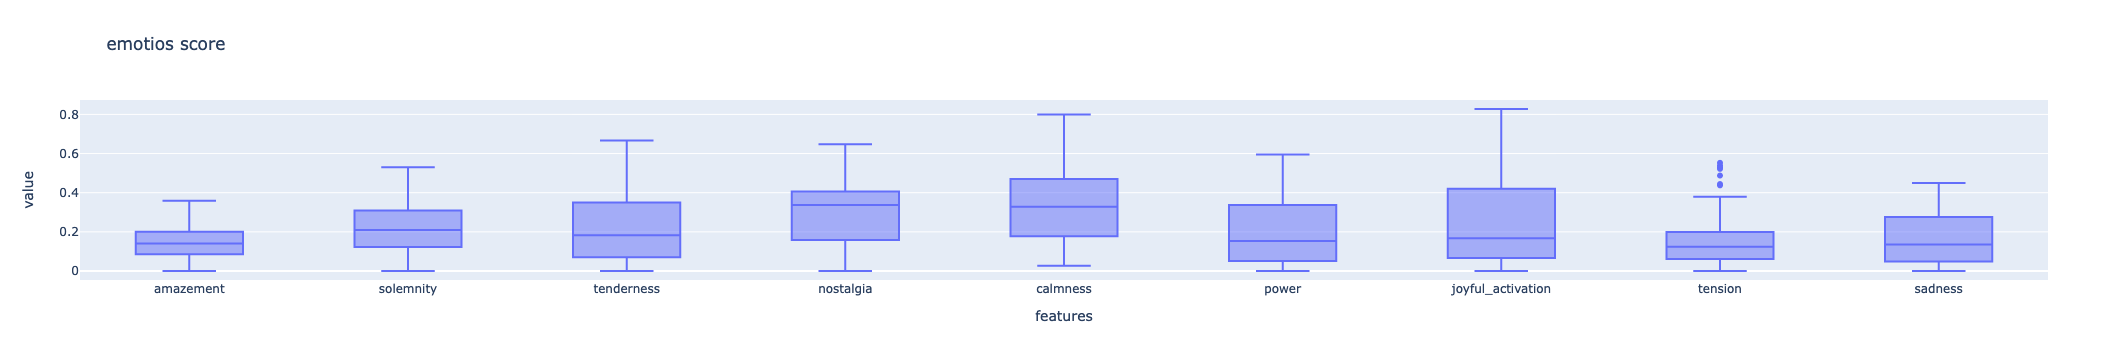

In [15]:
aux = emotions.copy()
aux = aux.set_index('sample').T.reset_index().rename(columns={'index': 'features'})
aux = aux.melt( id_vars='features', var_name='sample', value_name='value' )

fig = px.box( aux, x='features', y='value', title='emotios score')
fig.show()

In [16]:
"""

    train/test split

"""

size = 0.2

sample = np.random.permutation( emotions['sample'] )

n = int( size * len(sample) )
train, test = sample[ n : ], sample[ : n ]

emotions['train'] = 0
emotions.loc[ emotions['sample'].isin( train ), 'train' ] = 1

print('\nsplit size: ')
emotions['train'].value_counts(normalize=True)


split size: 


1    0.8
0    0.2
Name: train, dtype: float64

In [17]:
"""

    train features

"""

train = emotions[ emotions['train'] == 1 ].merge( ch_df, on='sample', how='left' )

print(f'\ntotal number of chords: {train["chord"].nunique()}')
print(f'\ntotal number of root chords: {train["chord_root"].nunique()}')

# initialize features dataframe

train_features = pd.DataFrame()

# number of chords normalized with respect to the chords observed in the corpus

train_features = train.groupby(['sample'])['chord'].nunique().reset_index().copy()

# number of root chords normalized with respect to the root chords observed in the corpus

aux = train.groupby(['sample'])['chord_root'].nunique().reset_index().copy()
train_features = train_features.merge(aux, on='sample', how='right')

# root chord duration normalized with respect to the track duration

aux = train.groupby(['sample', 'chord_root'])['chord_duration'].sum().reset_index(name='duration')
aux['total'] = aux.groupby('sample')['duration'].transform('sum')
aux['norm_duration'] = aux['duration'] / aux['total']
aux = aux.pivot( index='sample', columns='chord_root', values='norm_duration' ).reset_index().fillna(0.0)
aux.columns = [ x + '_d' if x != 'sample' else 'sample' for x in aux.columns ]
train_features = train_features.merge(aux, on='sample', how='right')

# chords representation

aux = train.groupby(['sample', 'chord_root']).size().reset_index(name='count')
aux['total'] = aux.groupby('sample')['count'].transform('sum')
aux['norm_count'] = aux['count'] / aux['total']
aux = aux.pivot(index='sample', columns='chord_root', values='norm_count').reset_index().fillna(0.0)
train_features = train_features.merge( aux, on='sample', how='right' )

# features dataframe

features = [ x for x in train_features if x not in ['sample'] ]
train_features = train_features[ ['sample'] + features ]

print(f'\nfeatures: \n{features}')
train_features.head()


total number of chords: 106

total number of root chords: 12

features: 
['chord', 'chord_root', 'A_d', 'Ab_d', 'B_d', 'Bb_d', 'C_d', 'C#_d', 'D_d', 'E_d', 'Eb_d', 'F_d', 'F#_d', 'G_d', 'A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'E', 'Eb', 'F', 'F#', 'G']


sample  chord  chord_root       A_d      Ab_d       B_d      Bb_d       C_d  \
0     10     14           7  0.000000  0.475645  0.021968  0.048711  0.030564   
1    101     18           6  0.279272  0.000000  0.034019  0.075949  0.162975   
2    103     13           8  0.261277  0.000000  0.211064  0.000000  0.057021   
3    105     13           8  0.096939  0.000000  0.000000  0.142857  0.018707   
4    106     14           7  0.238019  0.046326  0.134984  0.000000  0.000000   

       C#_d       D_d  ...         B        Bb         C        C#         D  \
0  0.177650  0.000000  ...  0.026316  0.078947  0.026316  0.210526  0.000000   
1  0.000000  0.267405  ...  0.048780  0.048780  0.097561  0.000000  0.341463   
2  0.000000  0.000000  ...  0.192308  0.000000  0.076923  0.000000  0.000000   
3  0.000000  0.483844  ...  0.000000  0.135135  0.027027  0.000000  0.459459   
4  0.059105  0.095847  ...  0.142857  0.000000  0.000000  0.057143  0.057143   

          E        Eb         F        F#         G  
0  0.052632  0.236842  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.073171  0.000000  0.000000  
2  0.230769  0.076923  0.038462  0.076923  0.153846  
3  0.081081  0.054054  0.081081  0.000000  0.054054  
4  0.257143  0.000000  0.000000  0.171429  0.000000  

[5 rows x 27 columns]

In [18]:
"""

    test features

"""

test = emotions[ emotions['train'] == 0 ].merge( ch_df, on='sample', how='left' )

print(f'\ntotal number of chords: {test["chord"].nunique()}')
print(f'\ntotal number of root chords: {test["chord_root"].nunique()}')

# initialize features dataframe

test_features = pd.DataFrame()

# number of chords normalized with respect to the chords observed in the corpus

test_features = test.groupby(['sample'])['chord'].nunique().reset_index().copy()
test_features['chord_norm'] = test_features['chord'] / test['chord'].nunique()

# number of root chords normalized with respect to the root chords observed in the corpus

aux = test.groupby(['sample'])['chord_root'].nunique().reset_index().copy()
aux['chord_root_norm'] = aux['chord_root'] / test['chord_root'].nunique()

test_features = test_features.merge(aux, on='sample', how='right')

# root chord duration normalized with respect to the track duration

aux = test.groupby(['sample', 'chord_root'])['chord_duration'].sum().reset_index(name='duration')
aux['total'] = aux.groupby('sample')['duration'].transform('sum')
aux['norm_duration'] = aux['duration'] / aux['total']
aux = aux.pivot( index='sample', columns='chord_root', values='norm_duration' ).reset_index().fillna(0.0)
aux.columns = [ x + '_d' if x != 'sample' else 'sample' for x in aux.columns ]
test_features = test_features.merge(aux, on='sample', how='right')

# chords representation

aux = test.groupby(['sample', 'chord_root']).size().reset_index(name='count')
aux['total'] = aux.groupby('sample')['count'].transform('sum')
aux['norm_count'] = aux['count'] / aux['total']
aux = aux.pivot(index='sample', columns='chord_root', values='norm_count').reset_index().fillna(0.0)
test_features = test_features.merge( aux, on='sample', how='right' )

# features dataframe

features = [ x for x in test_features if x not in ['sample', 'chord_norm', 'chord_root_norm'] ]
test_features = test_features[ ['sample'] + features ]

print(f'\nfeatures: \n{features}')
test_features.head()


total number of chords: 82

total number of root chords: 12

features: 
['chord', 'chord_root', 'A_d', 'Ab_d', 'B_d', 'Bb_d', 'C_d', 'C#_d', 'D_d', 'E_d', 'Eb_d', 'F_d', 'F#_d', 'G_d', 'A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'E', 'Eb', 'F', 'F#', 'G']


sample  chord  chord_root       A_d      Ab_d       B_d      Bb_d       C_d  \
0      1     30          10  0.059247  0.183347  0.034428  0.019215  0.013611   
1    102     12           5  0.000000  0.000000  0.046603  0.000000  0.487362   
2    104     20           8  0.230586  0.000000  0.000000  0.397781  0.044374   
3    113      9           6  0.073841  0.000000  0.153181  0.000000  0.461115   
4    115      9           5  0.000000  0.000000  0.373239  0.000000  0.000000   

       C#_d       D_d  ...         B        Bb         C        C#         D  \
0  0.183347  0.000000  ...  0.063830  0.021277  0.021277  0.212766  0.000000   
1  0.000000  0.049763  ...  0.035714  0.000000  0.357143  0.000000  0.107143   
2  0.000000  0.088748  ...  0.000000  0.090909  0.090909  0.000000  0.212121   
3  0.000000  0.000000  ...  0.115385  0.000000  0.423077  0.000000  0.000000   
4  0.000000  0.182316  ...  0.333333  0.000000  0.000000  0.000000  0.222222   

          E        Eb         F        F#         G  
0  0.106383  0.106383  0.000000  0.212766  0.021277  
1  0.107143  0.000000  0.000000  0.000000  0.392857  
2  0.121212  0.000000  0.030303  0.030303  0.151515  
3  0.038462  0.000000  0.076923  0.000000  0.192308  
4  0.074074  0.000000  0.000000  0.037037  0.333333  

[5 rows x 27 columns]

<Axes: >

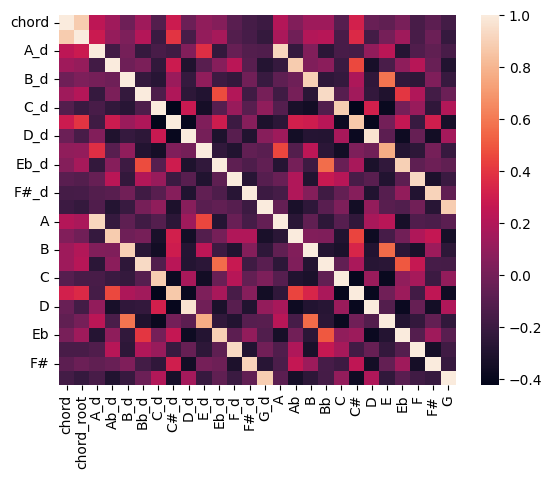

In [19]:
"""

    train correlation map

"""

seaborn.heatmap( train_features[ features ].corr(), ) 

<Axes: >

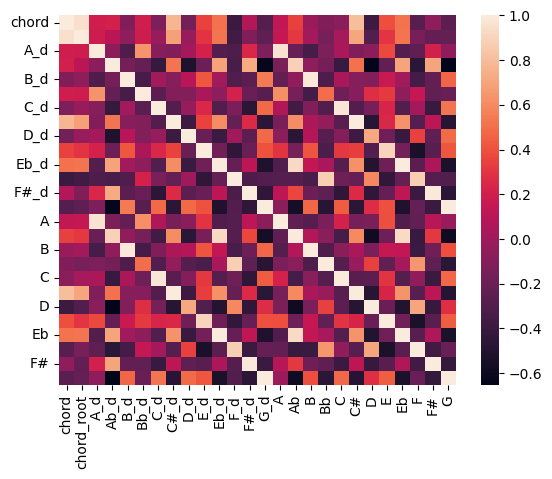

In [20]:
"""

    test correlation map

"""

seaborn.heatmap( test_features[ features ].corr(), )  

In [21]:
"""

    regressor model for calmness

"""

X_train = train_features[ features ]

X_test = test_features[ features ]

emo_set = sorted([ x for x in emotions if x not in ['sample', 'train'] ])

for e in emo_set:
    
    print(f'----------- {e} --------------')
    
    y_train = emotions[ emotions['sample'].isin( train_features['sample'].unique() ) ][ e ].values
    y_test = emotions[ emotions['sample'].isin( test_features['sample'].unique() ) ][ e ].values
    
    print(f'\nX train: {X_train.shape}')
    print(f'y train: {y_train.shape}')

    print(f'\nX test: {X_test.shape}')
    print(f'y test: {y_test.shape}\n')
    
    # select the k best fitting features
    selector = SelectKBest(k=15)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    print(f'\nX train selected: {X_train_selected.shape}')
    print(f'X test selected: {X_test_selected.shape}')
    
    feature_names = X_train.columns[selector.get_support(indices=True)].tolist()
    print(f'\nbest k features: {feature_names}')
    
    # grid search 
    
    param_grid_linear = {'fit_intercept': [True, False]}
    grid_linear_reg = GridSearchCV(LinearRegression(), param_grid_linear, cv=5)
    grid_linear_reg.fit(X_train_selected, y_train)
    best_params_linear_reg = grid_linear_reg.best_params_

    param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 15, 20, 100, 200, 500], 'fit_intercept': [True, False], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}
    grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
    grid_ridge.fit(X_train_selected, y_train)
    best_params_ridge = grid_ridge.best_params_

    param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10], 'fit_intercept': [True, False], 'selection': ['cyclic', 'random']}
    grid_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5)
    grid_lasso.fit(X_train_selected, y_train)
    best_params_lasso = grid_lasso.best_params_

    param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 50], 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 'max_features': ['sqrt', 'log2', None]}
    grid_rf_reg = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3)
    grid_rf_reg.fit(X_train_selected, y_train)
    best_params_rf_reg = grid_rf_reg.best_params_
    
    print(f'\nbest parameters linear regression: {best_params_linear_reg}')
    print(f'best parameters ridge: {best_params_ridge}')
    print(f'best parameters lasso: {best_params_lasso}')
    print(f'best parameters random forest regressor: {best_params_rf_reg}')
    
    # performance comparisson
    linear_reg = LinearRegression(fit_intercept=best_params_linear_reg['fit_intercept'])
    linear_reg.fit(X_train_selected, y_train)
    y_pred_linear_reg = linear_reg.predict(X_test_selected)
    mse_linear_reg = mean_squared_error(y_test, y_pred_linear_reg)
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)

    ridge = Ridge(alpha=best_params_ridge['alpha'])
    ridge.fit(X_train_selected, y_train)
    y_pred_ridge = ridge.predict(X_test_selected)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    lasso = Lasso(alpha=best_params_lasso['alpha'])
    lasso.fit(X_train_selected, y_train)
    y_pred_lasso = lasso.predict(X_test_selected)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)

    rf_reg = RandomForestRegressor(n_estimators=best_params_rf_reg['n_estimators'], max_depth=best_params_rf_reg['max_depth'], random_state=42)
    rf_reg.fit(X_train_selected, y_train)
    y_pred_rf_reg = rf_reg.predict(X_test_selected)
    mse_rf_reg = mean_squared_error(y_test, y_pred_rf_reg)
    r2_rf_reg = r2_score(y_test, y_pred_rf_reg)
    
    print(f'\nmse, r2 linear regression: {mse_linear_reg, r2_linear_reg}')
    print(f'mse, r2 ridge: {mse_ridge, r2_ridge}')
    print(f'mse, r2 lasso: {mse_lasso, r2_lasso}')
    print(f'mse, r2 random forest regressor: {mse_rf_reg, r2_rf_reg}\n')
    print(f'mse, r2 mean: { mean_squared_error(y_test, np.full( shape=len(y_test), fill_value=np.mean(y_train) )), r2_score(y_test, np.full( shape=len(y_test), fill_value=np.mean(y_train) )) }')

----------- amazement --------------

X train: (47, 26)
y train: (47,)

X test: (12, 26)
y test: (12,)


X train selected: (47, 15)
X test selected: (12, 15)

best k features: ['chord', 'chord_root', 'Ab_d', 'B_d', 'Bb_d', 'C_d', 'C#_d', 'G_d', 'Ab', 'B', 'C', 'C#', 'Eb', 'F#', 'G']

best parameters linear regression: {'fit_intercept': True}
best parameters ridge: {'alpha': 500, 'fit_intercept': True, 'solver': 'lsqr'}
best parameters lasso: {'alpha': 1, 'fit_intercept': True, 'selection': 'cyclic'}
best parameters random forest regressor: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

mse, r2 linear regression: (0.008594392410207305, -0.3898156208740744)
mse, r2 ridge: (0.0071160607210146104, -0.1507517782651464)
mse, r2 lasso: (0.0067469560208239035, -0.09106315182381386)
mse, r2 random forest regressor: (0.009659476565999997, -0.5620524151247168)

mse, r2 mean: (0.0067469560208239035, -0.09106315182381386)
----------- calmness -------

**- Data preparation**

**The dataset is split 80:20 for training and test respectively.**

**- Feature selection**

**Out of the total number of 26 features, only 15 were selected based on their performance during the validation process.**

**- Learning algorithms**

**Four learning algorithms were used to adjust the approximation function. The hyperparameters of each algorithm were selected using Grid Search based on observations made during the training and validation process.**

**- Validation**

**The proposed models were validatred using cross validation with k=5 due to the size of the sample space**

**- Test performance**

**To evaluate the performance of the models, we used the mean of the training observations as a benchmark. While the mean squared error (MSE) and R-squared (R2) improved in at least one of the models, the improvements were not as significant as expected based on theoretical assumptions. This could be due to the small sample size or the weak relationship between the extracted chord features and certain emotions. Furthermore, the original distribution of the emotions indicates that the upper and lower bounds of the scores are not uniformly distributed, which could also impact the performance of the models.**

#### <font color='red'> What were your best features?  </font>

**Overall, the most important features for each regressor appear to be those related to the timing of the chords and the count of chords observed in the tracks. These findings suggest that the timing and count of chords may play a significant role in predicting emotions in music.**

#### <font color='red'> How long did it take you to do this homework? Do you have any comments on how to improve it? </font>

**This homework took me approximately five days to complete. The majority of this time was spent becoming familiar with the chords and emotions dataset. Overall, the assignment proved to be a valuable learning experience that allowed me to develop a deeper understanding of the relationship between music and emotions.**